In [1]:
import numpy as np              # numpy is a general-purpose math package
import yt                       # yt is the data vizualization package
from yt.units import *          # this lets you get things like speed of light in proper units just by typing 'c'
from astropy.table import Table # this is needed for reading in various foggie data byproducts
from astropy.io import ascii    # this too
import matplotlib.pyplot as plt # this is the standard python plotting package, very useful!
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import math
from ipynb.fs.defs.FRB_and_Projection_functions import frb_projection, projection
from scipy import optimize
import pwlf # A library for fitting continuous piecewise linear functions to data (Returns cut-off radius)
import os #for the lacie part 

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.foggie_load import *

home_dir = '/Users/hylee/foggie/'
laptop_root_dir = home_dir + 'foggie_sims/' # root directory where sims are stored on the laptop
hd_root_dir = '/Volumes/LaCie/' # root directory where sims are stored on the hard drive

root_dir = hd_root_dir # have this as either laptop_root_dir or hd_root_dir depending on where the simulation is stored
code_path = '/Users/hylee/coding/foggie/foggie/' #path to the cloned github repo

# everything above this is general path, and below this is specific to a given halo
halo = '8508' # which halo
simulation_dir = root_dir + 'halo_00' + halo + '/nref11c_nref9f/' # path where the foggie simulations are stored
output_dir = home_dir + 'foggie_output/halo_00' + halo + '/nref11c_nref9f/Density_cutoff_y/' # path where all the outputs will be stored
track_dir = code_path + 'halo_infos/00' + halo + '/nref11c_nref9f/'
track_name = code_path + 'halo_tracks/00' + halo + '/nref11n_selfshield_15/halo_track_200kpc_nref9' #these need to be provided to foggie_load()

In [2]:
def radius_func(od, size, res):
    OD_Qua=[]
    OD_Rad=[]  #OD_Rad & OD_Met HAVE to be defined specifically inside func1/before for loop
    for i in range(70):
        for j in range(70):
            this_quantity_value = od[i][j]
            xindex = i
            yindex = j
            radius = (math.sqrt(((yindex-34)**2+(xindex-34)**2)))*(size/res)
            OD_Qua.append(this_quantity_value)
            OD_Rad.append(radius)
    return OD_Rad, OD_Qua

In [3]:
def binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize):
    index = 0 
    quantitylist = []
    sort = np.argsort(OD_Rad)
    sorted_radius = np.array(OD_Rad)[sort]
    sorted_quantity = np.array(OD_Qua)[sort]
    radiuslist = np.arange(min_radius, max_radius, binsize) + binsize/2
    while index < len(radiuslist):
        left_edge = index*binsize
        right_edge = left_edge + binsize 
        new_quantity = np.array(sorted_quantity)[(left_edge <= sorted_radius) & (sorted_radius < right_edge)]
        quantitylist.append((np.mean(new_quantity)))
        index +=1
    return radiuslist, quantitylist

In [4]:
def piecewise_linear(x, x0, y0, k1, k2): 
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [5]:
def plotting(xvalue, yvalue_origdata, yvalue_cutoff, color_original, color_cutoff, plotlabel_linedot,
            plotlabel_segment):
    fig1 = plt.figure()
    plt.plot(xvalue, yvalue_origdata, color_original, label=plotlabel_linedot)
    plt.plot(xvalue, yvalue_cutoff, color_cutoff, label=plotlabel_segment)
    plt.legend(loc="upper right", fontsize = 15)
    plt.xlabel("Radius from galactic center [kpc]", fontsize = fontsize)
    plt.ylabel("Projected density [log 10 g/cm^2]", fontsize = fontsize)
    plt.xticks(fontsize = fontsize/1.5)
    plt.yticks(fontsize = fontsize/1.5)
    return fig1

In [6]:
DDLIST = []
for file in os.listdir(simulation_dir):
    if file.startswith("DD"):
        DDLIST.append(file)
sorted_dd_list = sorted(DDLIST, key=lambda x: int(x[2:]))

In [7]:
field = "density"
axis = "y" 
resolution = 70 #[pixel]
colorlabel = 'Projected density [log 10 g/cm^2]'
min_radius = 0  #[kpc]
markersize = 10
fontsize = 20 
plotlabel_linedot = 'Binned mean density'

yt : [INFO     ] 2023-07-27 10:44:25,816 Parameters: current_time              = 67.566527818285
yt : [INFO     ] 2023-07-27 10:44:25,817 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:44:25,818 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:44:25,818 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:44:25,819 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:44:25,819 Parameters: current_redshift          = 4.2560468529995
yt : [INFO     ] 2023-07-27 10:44:25,820 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:44:25,821 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:44:25,821 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:44:25,822 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0138/DD0138
get_refine_box: using this location:     col1      col2     col3     col4     col5     col6     col7   col8
----------- -------- -------- -------- -------- -------- -------- ----
4.256046853 0.494908 0.492937 0.500048 0.496908 0.494937 0.502048    9


Parsing Hierarchy : 100%|█████████████████| 5116/5116 [00:00<00:00, 8614.71it/s]
yt : [INFO     ] 2023-07-27 10:44:26,667 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:44:32,154 Projection completed
yt : [INFO     ] 2023-07-27 10:44:32,156 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/var/folders/d8/fhyrhkwj0gn9mv61yhxy4srw0005m7/T/ipykernel_42765/2370319974.py:32: RuntimeWarning: divide by zero encountered in log10
  p , e = optimize.curve_fit(piecewise_linear, radiuslist, np.log10(quantitylist),
yt : [INFO     ] 2023-07-27 10:44:32,235 Parameters: current_time              = 92.566527818285
yt : [INFO     ] 2023-07-27 10:44:32,236 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:44:32,236 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:44:32,237 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:44:32,237 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:44:32,238 Parameters: current_redshift          = 3.2538800161868
yt : [INFO     ] 2023-07-27 10:44:32,239 Parameters: omeg

Error with DD0138
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0238/DD0238
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
3.25388001619 0.494301 0.491267 0.500132 0.496301 0.493267 0.502132    9


Parsing Hierarchy : 100%|███████████████| 11675/11675 [00:01<00:00, 9892.61it/s]
yt : [INFO     ] 2023-07-27 10:44:33,764 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:44:46,215 Projection completed
yt : [INFO     ] 2023-07-27 10:44:46,216 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


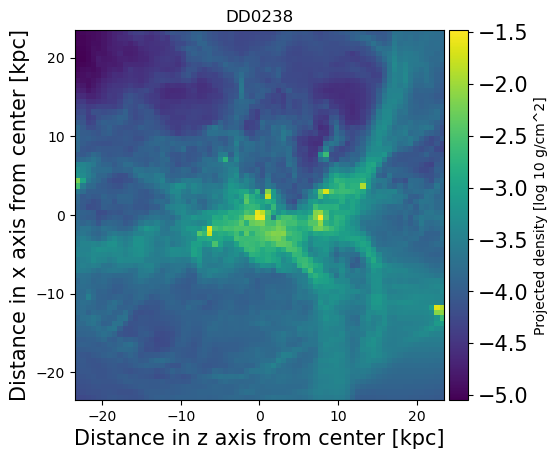

yt : [INFO     ] 2023-07-27 10:44:46,703 Parameters: current_time              = 104.81652781829
yt : [INFO     ] 2023-07-27 10:44:46,704 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:44:46,704 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:44:46,705 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:44:46,706 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:44:46,707 Parameters: current_redshift          = 2.9116806075987
yt : [INFO     ] 2023-07-27 10:44:46,707 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:44:46,708 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:44:46,709 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:44:46,709 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0287/DD0287
get_refine_box: using this location:     col1       col2     col3     col4     col5     col6     col7   col8
------------ -------- -------- -------- -------- -------- -------- ----
2.9116806076 0.493954 0.490721 0.500203 0.495954 0.492721 0.502203    9


Parsing Hierarchy : 100%|████████████████| 7384/7384 [00:00<00:00, 11429.88it/s]
yt : [INFO     ] 2023-07-27 10:44:47,600 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:44:54,679 Projection completed
yt : [INFO     ] 2023-07-27 10:44:54,681 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


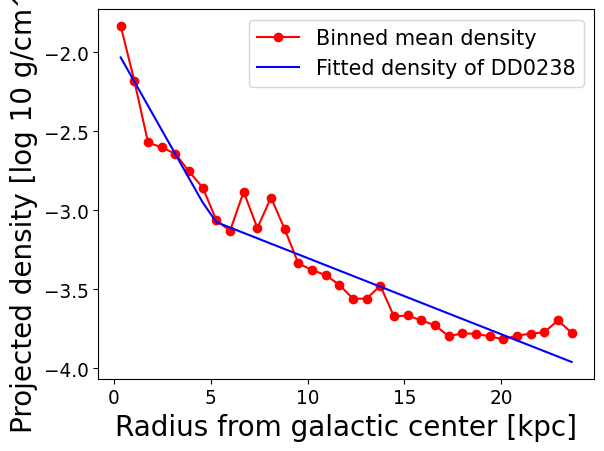

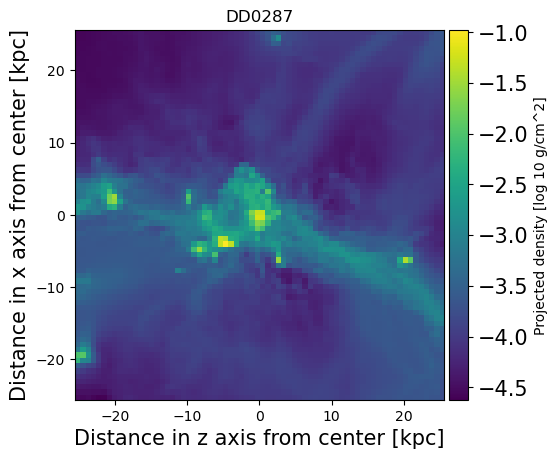

yt : [INFO     ] 2023-07-27 10:44:55,235 Parameters: current_time              = 106.31652781829
yt : [INFO     ] 2023-07-27 10:44:55,236 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:44:55,236 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:44:55,237 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:44:55,238 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:44:55,239 Parameters: current_redshift          = 2.8742891413864
yt : [INFO     ] 2023-07-27 10:44:55,239 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:44:55,240 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:44:55,240 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:44:55,241 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0293/DD0293
get_refine_box: using this location:      col1       col2     col3     col4    col5     col6     col7  col8
------------- -------- -------- ------- -------- -------- ------- ----
2.87428914139 0.493962 0.490687 0.50017 0.495962 0.492687 0.50217    9


Parsing Hierarchy : 100%|█████████████████| 7297/7297 [00:01<00:00, 5638.16it/s]
yt : [INFO     ] 2023-07-27 10:44:56,838 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:45:05,295 Projection completed
yt : [INFO     ] 2023-07-27 10:45:05,300 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


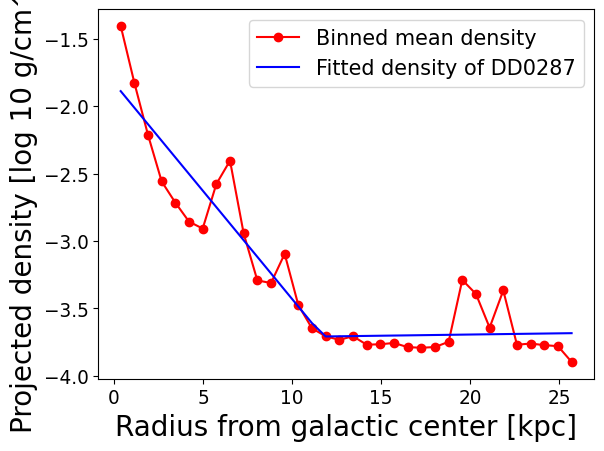

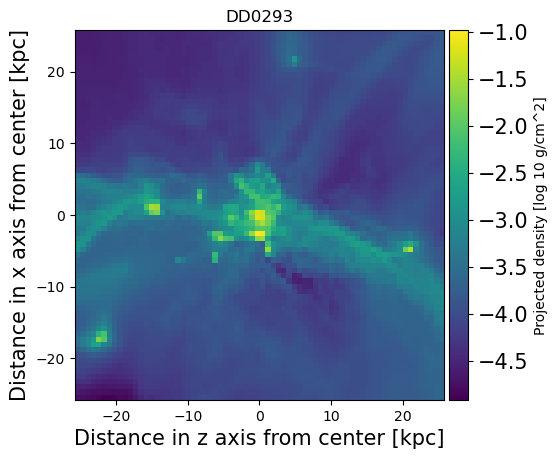

yt : [INFO     ] 2023-07-27 10:45:06,063 Parameters: current_time              = 117.56652781829
yt : [INFO     ] 2023-07-27 10:45:06,064 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:45:06,065 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:45:06,066 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:45:06,067 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:45:06,067 Parameters: current_redshift          = 2.6192132579666
yt : [INFO     ] 2023-07-27 10:45:06,068 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:45:06,069 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:45:06,070 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:45:06,071 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0338/DD0338
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.61921325797 0.493773 0.490067 0.500353 0.495773 0.492067 0.502353    9


Parsing Hierarchy : 100%|█████████████████| 8624/8624 [00:01<00:00, 7923.60it/s]
yt : [INFO     ] 2023-07-27 10:45:07,489 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:45:49,821 Projection completed
yt : [INFO     ] 2023-07-27 10:45:49,823 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


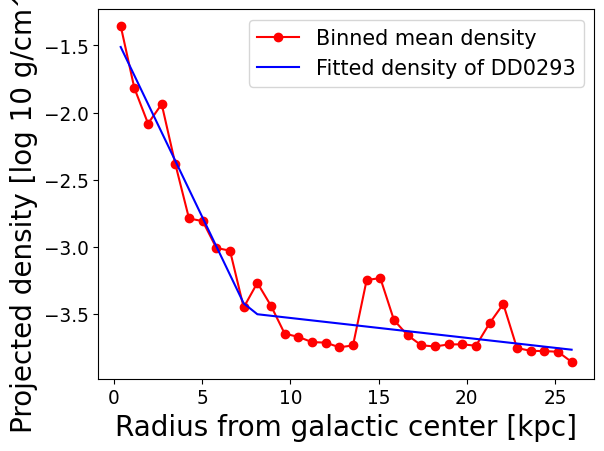

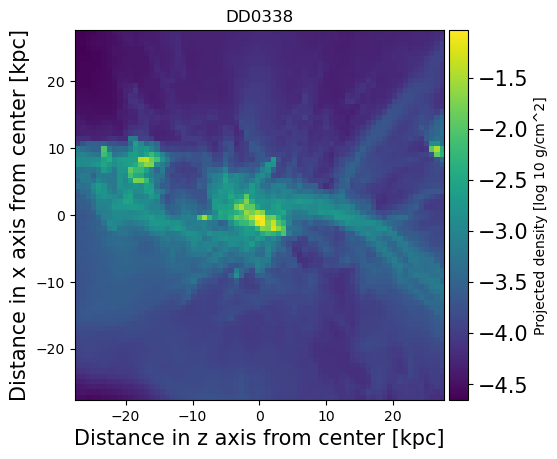

yt : [INFO     ] 2023-07-27 10:45:50,387 Parameters: current_time              = 142.56652781829
yt : [INFO     ] 2023-07-27 10:45:50,388 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:45:50,389 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:45:50,390 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:45:50,390 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:45:50,391 Parameters: current_redshift          = 2.174064272558
yt : [INFO     ] 2023-07-27 10:45:50,392 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:45:50,392 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:45:50,393 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:45:50,394 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0438/DD0438
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.17406427256 0.493252 0.488579 0.500941 0.495252 0.490579 0.502941    9


Parsing Hierarchy : 100%|████████████████| 9619/9619 [00:00<00:00, 10199.33it/s]
yt : [INFO     ] 2023-07-27 10:45:51,645 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:47:52,910 Projection completed
yt : [INFO     ] 2023-07-27 10:47:52,912 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


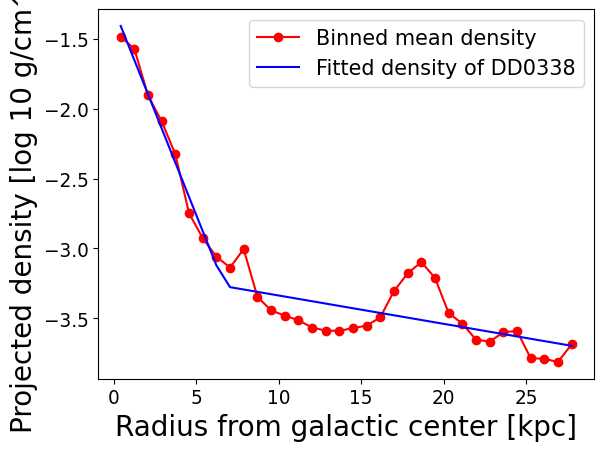

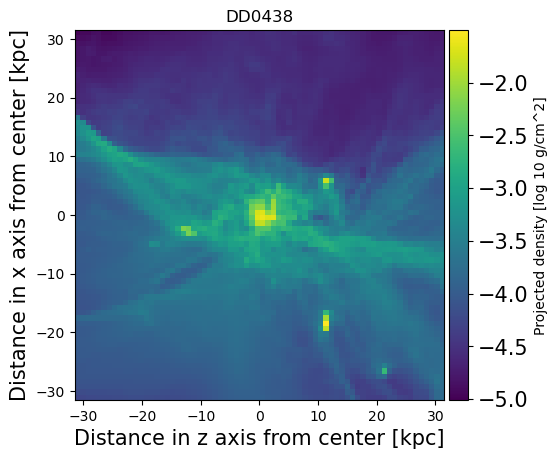

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0538/DD0538


yt : [INFO     ] 2023-07-27 10:47:53,681 Parameters: current_time              = 167.56652781829
yt : [INFO     ] 2023-07-27 10:47:53,682 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:47:53,684 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:47:53,685 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:47:53,686 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:47:53,686 Parameters: current_redshift          = 1.8407728906142
yt : [INFO     ] 2023-07-27 10:47:53,687 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:47:53,687 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:47:53,688 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:47:53,689 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
1.84077289061 0.492796 0.487204 0.501442 0.494796 0.489204 0.503442    9


Parsing Hierarchy : 100%|█████████████████| 6003/6003 [00:01<00:00, 5866.86it/s]
yt : [INFO     ] 2023-07-27 10:47:55,015 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:49:16,306 Projection completed
yt : [INFO     ] 2023-07-27 10:49:16,308 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


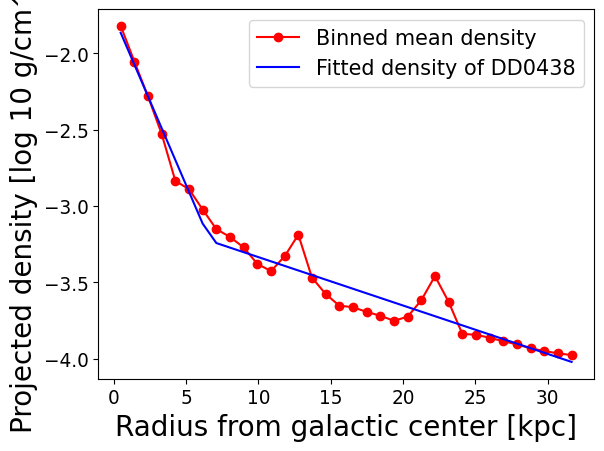

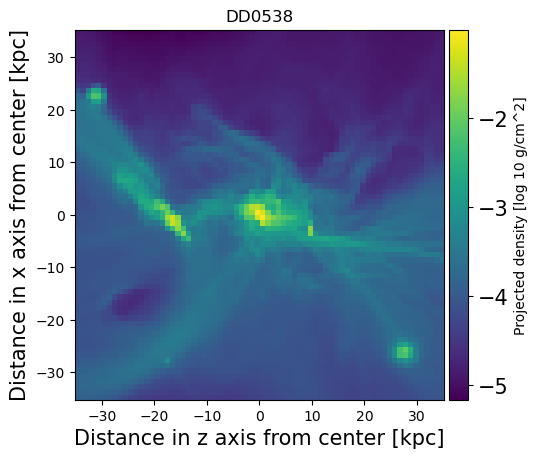

yt : [INFO     ] 2023-07-27 10:49:16,919 Parameters: current_time              = 192.56652781829
yt : [INFO     ] 2023-07-27 10:49:16,920 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:49:16,921 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:49:16,922 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:49:16,923 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:49:16,924 Parameters: current_redshift          = 1.5796008591072
yt : [INFO     ] 2023-07-27 10:49:16,924 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:49:16,925 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:49:16,925 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:49:16,926 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0638/DD0638
get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.57960085911 0.49248 0.485831 0.501973 0.49448 0.487831 0.503973    9


Parsing Hierarchy : 100%|█████████████████| 7363/7363 [00:01<00:00, 4556.33it/s]
yt : [INFO     ] 2023-07-27 10:49:18,820 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:50:52,123 Projection completed
yt : [INFO     ] 2023-07-27 10:50:52,125 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


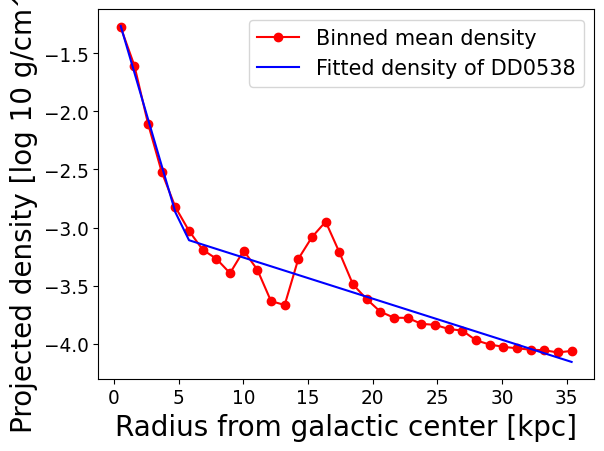

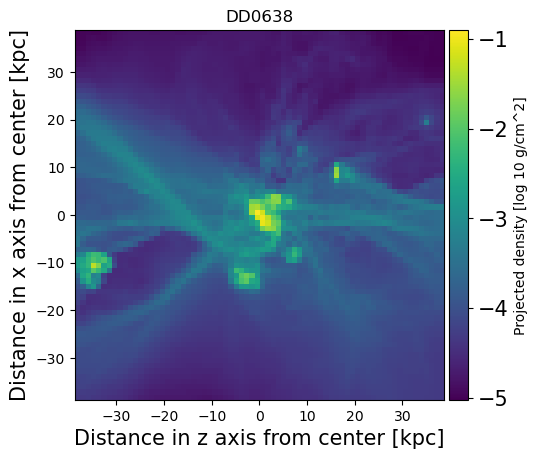

yt : [INFO     ] 2023-07-27 10:50:52,892 Parameters: current_time              = 217.56652781829
yt : [INFO     ] 2023-07-27 10:50:52,893 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:50:52,894 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:50:52,895 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:50:52,896 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:50:52,897 Parameters: current_redshift          = 1.3679320867642
yt : [INFO     ] 2023-07-27 10:50:52,898 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:50:52,898 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:50:52,899 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:50:52,900 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0738/DD0738
get_refine_box: using this location:      col1       col2    col3     col4    col5    col6     col7  col8
------------- ------- -------- ------- ------- -------- ------- ----
1.36793208676 0.49219 0.484532 0.50256 0.49419 0.486532 0.50456    9


Parsing Hierarchy : 100%|█████████████████| 8207/8207 [00:01<00:00, 7072.36it/s]
yt : [INFO     ] 2023-07-27 10:50:54,853 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:53:11,722 Projection completed
yt : [INFO     ] 2023-07-27 10:53:11,725 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


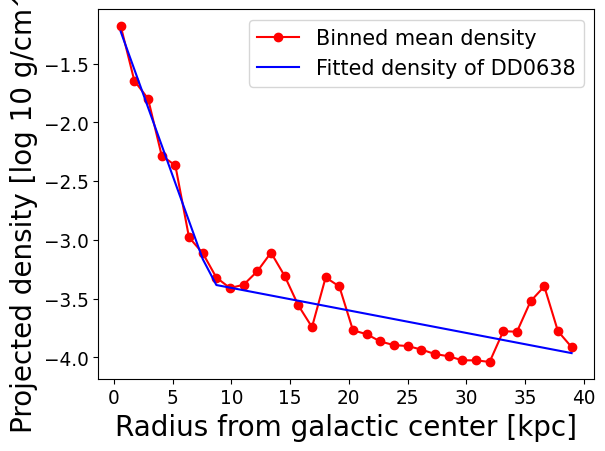

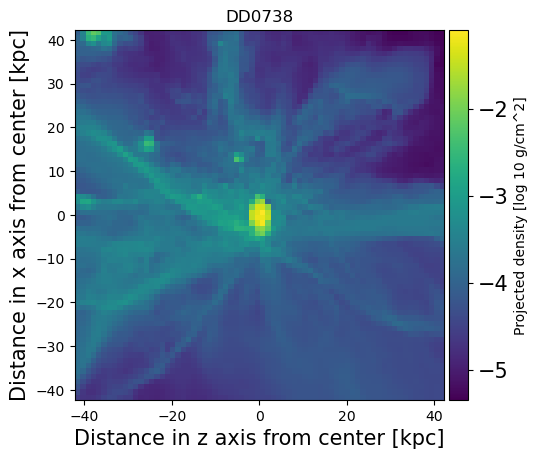

yt : [INFO     ] 2023-07-27 10:53:12,319 Parameters: current_time              = 242.56652781829
yt : [INFO     ] 2023-07-27 10:53:12,320 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:53:12,321 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:53:12,322 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:53:12,323 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:53:12,324 Parameters: current_redshift          = 1.1918720434881
yt : [INFO     ] 2023-07-27 10:53:12,324 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:53:12,325 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:53:12,326 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:53:12,326 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0838/DD0838
get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.19187204349 0.49185 0.483393 0.503033 0.49385 0.485393 0.505033    9


Parsing Hierarchy : 100%|█████████████████| 6414/6414 [00:01<00:00, 4988.65it/s]
yt : [INFO     ] 2023-07-27 10:53:13,921 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:55:53,573 Projection completed
yt : [INFO     ] 2023-07-27 10:55:53,574 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


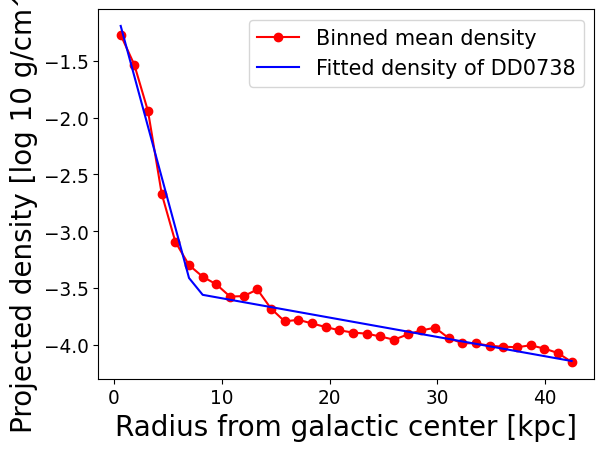

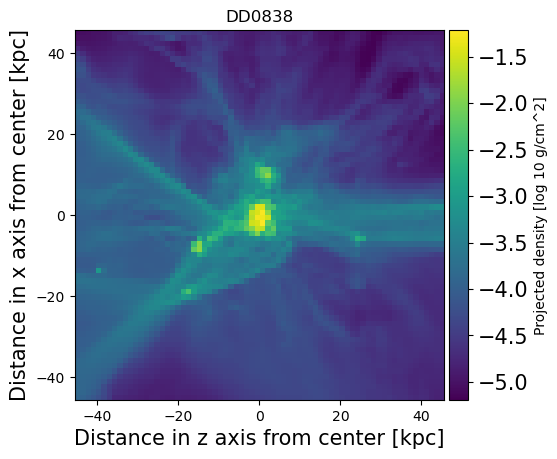

yt : [INFO     ] 2023-07-27 10:55:54,146 Parameters: current_time              = 267.56652781829
yt : [INFO     ] 2023-07-27 10:55:54,147 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:55:54,148 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:55:54,149 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:55:54,149 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:55:54,150 Parameters: current_redshift          = 1.0423765498971
yt : [INFO     ] 2023-07-27 10:55:54,150 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:55:54,151 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:55:54,151 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:55:54,152 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0938/DD0938
get_refine_box: using this location:     col1       col2     col3     col4     col5     col6     col7   col8
------------ -------- -------- -------- -------- -------- -------- ----
1.0423765499 0.491558 0.482256 0.503483 0.493558 0.484256 0.505483    9


Parsing Hierarchy : 100%|█████████████████| 6646/6646 [00:01<00:00, 4384.70it/s]
yt : [INFO     ] 2023-07-27 10:55:55,908 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:57:27,349 Projection completed
yt : [INFO     ] 2023-07-27 10:57:27,351 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


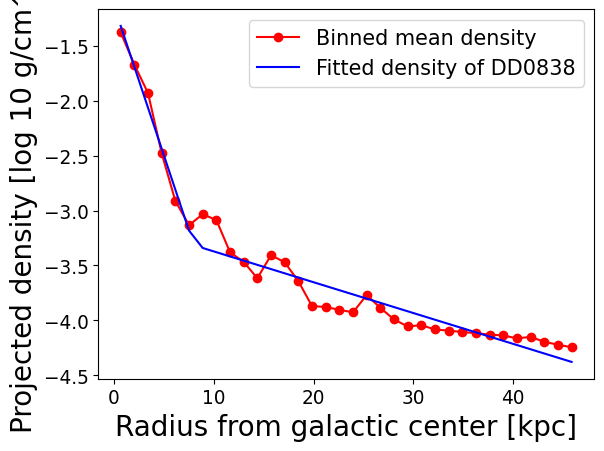

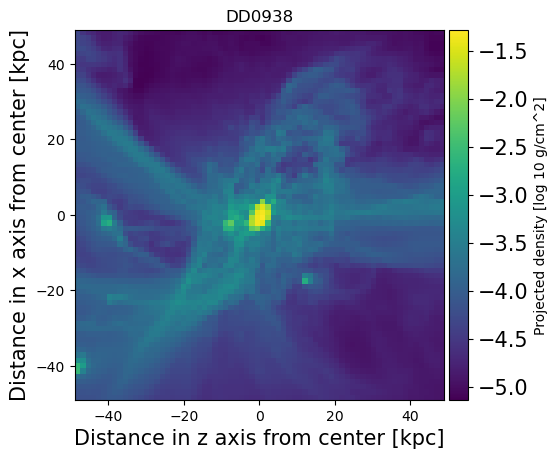

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1038/DD1038


yt : [INFO     ] 2023-07-27 10:57:28,198 Parameters: current_time              = 292.31652781829
yt : [INFO     ] 2023-07-27 10:57:28,198 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:57:28,199 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:57:28,200 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:57:28,201 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:57:28,202 Parameters: current_redshift          = 0.91449134314195
yt : [INFO     ] 2023-07-27 10:57:28,203 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:57:28,204 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:57:28,205 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:57:28,206 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1        col2     col3     col4     col5     col6     col7   col8
-------------- -------- -------- -------- -------- -------- -------- ----
0.914491343142 0.491324 0.481173 0.503918 0.493324 0.483173 0.505918    9


Parsing Hierarchy : 100%|█████████████████| 5369/5369 [00:00<00:00, 5670.93it/s]
yt : [INFO     ] 2023-07-27 10:57:29,800 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:58:41,463 Projection completed
yt : [INFO     ] 2023-07-27 10:58:41,465 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


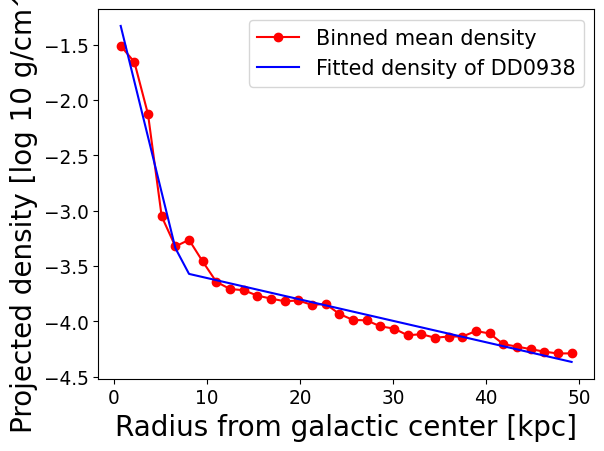

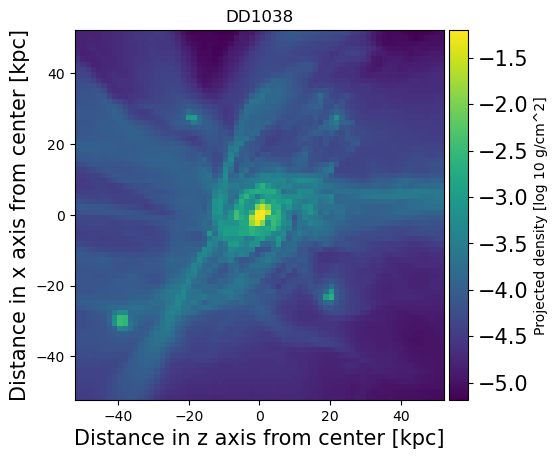

yt : [INFO     ] 2023-07-27 10:58:42,038 Parameters: current_time              = 317.31652781829
yt : [INFO     ] 2023-07-27 10:58:42,039 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:58:42,040 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:58:42,041 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:58:42,042 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:58:42,042 Parameters: current_redshift          = 0.80131183964773
yt : [INFO     ] 2023-07-27 10:58:42,043 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:58:42,044 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:58:42,045 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:58:42,046 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1138/DD1138
get_refine_box: using this location:       col1         col2    col3    col4     col5    col6    col7   col8
---------------- ------- ------- -------- ------- ------- -------- ----
0.80131183964773 0.49111 0.48016 0.504261 0.49311 0.48216 0.506261    9


Parsing Hierarchy : 100%|█████████████████| 5629/5629 [00:00<00:00, 7356.33it/s]
yt : [INFO     ] 2023-07-27 10:58:43,061 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 10:59:54,925 Projection completed
yt : [INFO     ] 2023-07-27 10:59:54,927 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


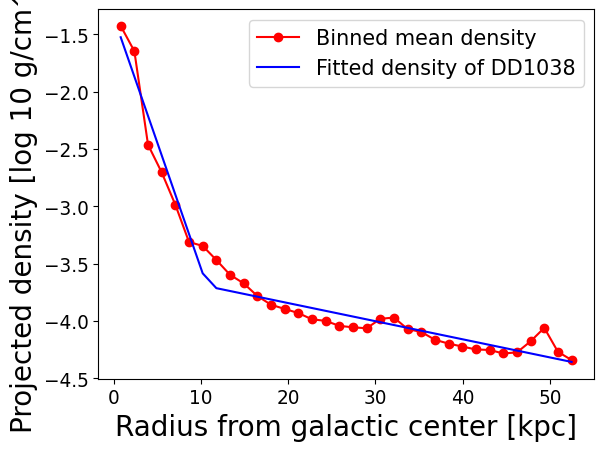

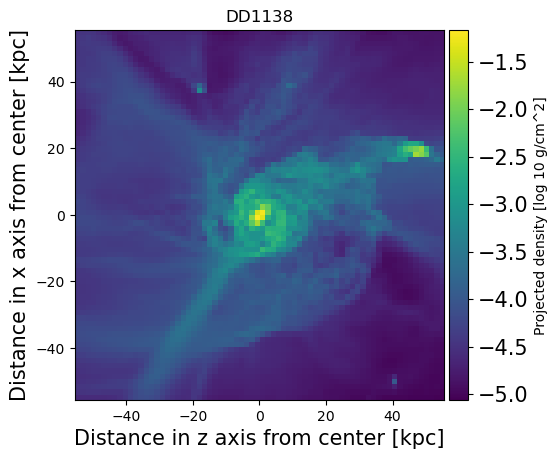

yt : [INFO     ] 2023-07-27 10:59:55,524 Parameters: current_time              = 342.31652781829
yt : [INFO     ] 2023-07-27 10:59:55,525 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 10:59:55,526 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 10:59:55,527 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 10:59:55,527 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 10:59:55,528 Parameters: current_redshift          = 0.70104740107777
yt : [INFO     ] 2023-07-27 10:59:55,529 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 10:59:55,530 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 10:59:55,530 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 10:59:55,531 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1238/DD1238
get_refine_box: using this location:       col1         col2    col3     col4     col5    col6     col7   col8
---------------- ------- -------- -------- ------- -------- -------- ----
0.70104740107777 0.49091 0.479176 0.504679 0.49291 0.481176 0.506679    9


Parsing Hierarchy : 100%|█████████████████| 6009/6009 [00:00<00:00, 6940.36it/s]
yt : [INFO     ] 2023-07-27 10:59:56,725 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:00:03,094 Projection completed
yt : [INFO     ] 2023-07-27 11:00:03,095 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


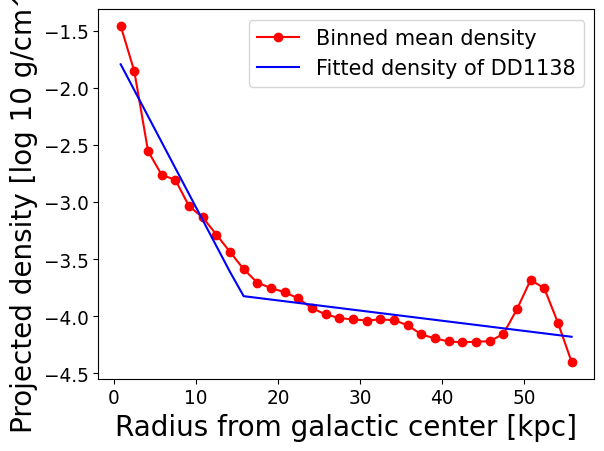

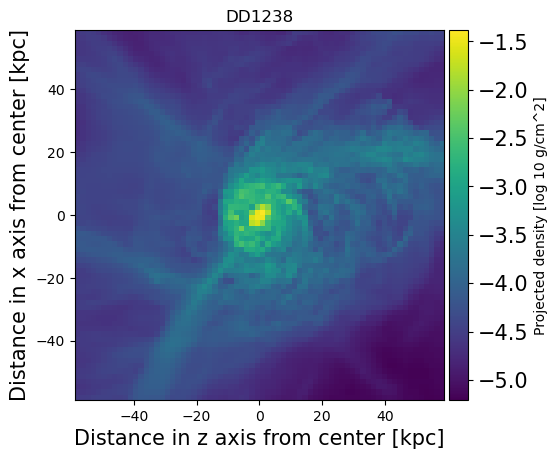

yt : [INFO     ] 2023-07-27 11:00:03,736 Parameters: current_time              = 367.31652781829
yt : [INFO     ] 2023-07-27 11:00:03,736 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:00:03,737 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:00:03,738 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:00:03,738 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:00:03,739 Parameters: current_redshift          = 0.61132831909135
yt : [INFO     ] 2023-07-27 11:00:03,740 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:00:03,740 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:00:03,741 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 11:00:03,742 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1338/DD1338
get_refine_box: using this location:       col1         col2     col3    col4     col5     col6    col7   col8
---------------- -------- ------- -------- -------- ------- -------- ----
0.61132831909135 0.490681 0.47823 0.505093 0.492681 0.48023 0.507093    9


Parsing Hierarchy : 100%|█████████████████| 6366/6366 [00:00<00:00, 7967.56it/s]
yt : [INFO     ] 2023-07-27 11:00:04,793 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:01:22,576 Projection completed
yt : [INFO     ] 2023-07-27 11:01:22,577 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


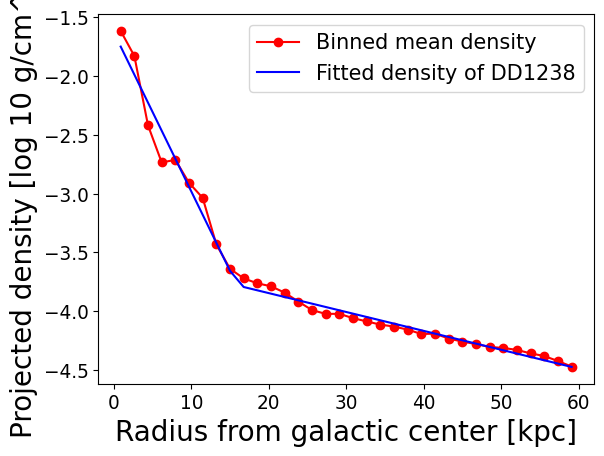

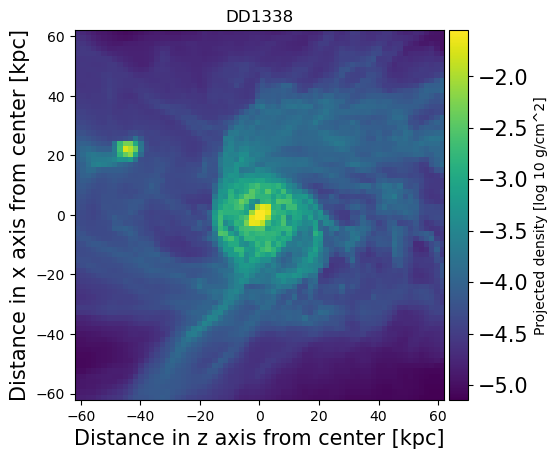

yt : [INFO     ] 2023-07-27 11:01:23,244 Parameters: current_time              = 392.31652781829
yt : [INFO     ] 2023-07-27 11:01:23,245 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:01:23,246 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:01:23,247 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:01:23,248 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:01:23,249 Parameters: current_redshift          = 0.53034842583426
yt : [INFO     ] 2023-07-27 11:01:23,250 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:01:23,250 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:01:23,251 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 11:01:23,252 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1438/DD1438
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.53034842583426 0.490464 0.477354 0.505497 0.492464 0.479354 0.507497    9


Parsing Hierarchy : 100%|█████████████████| 6029/6029 [00:00<00:00, 6998.42it/s]
yt : [INFO     ] 2023-07-27 11:01:24,424 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:02:41,415 Projection completed
yt : [INFO     ] 2023-07-27 11:02:41,417 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


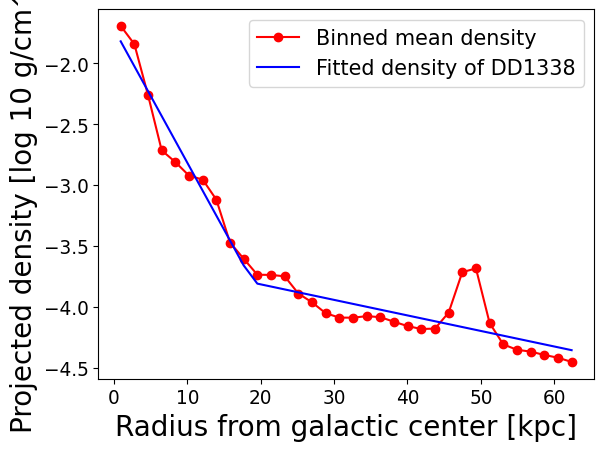

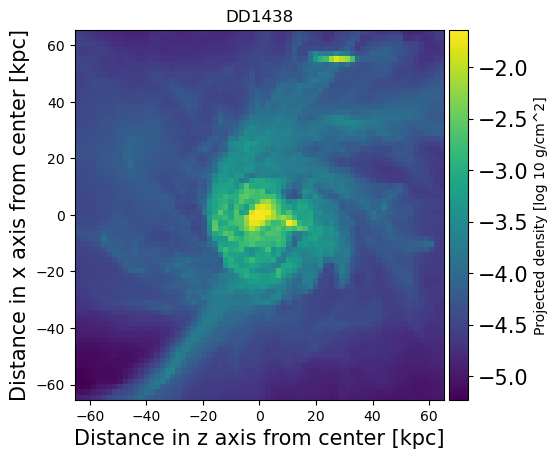

yt : [INFO     ] 2023-07-27 11:02:42,552 Parameters: current_time              = 402.06652781829
yt : [INFO     ] 2023-07-27 11:02:42,552 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:02:42,553 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:02:42,554 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:02:42,555 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:02:42,556 Parameters: current_redshift          = 0.50082158855578
yt : [INFO     ] 2023-07-27 11:02:42,557 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:02:42,558 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:02:42,558 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 11:02:42,559 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1477/DD1477
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.50082158855578 0.490382 0.477019 0.505663 0.492382 0.479019 0.507663    9


Parsing Hierarchy : 100%|█████████████████| 6066/6066 [00:00<00:00, 7503.12it/s]
yt : [INFO     ] 2023-07-27 11:02:43,629 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:04:05,649 Projection completed
yt : [INFO     ] 2023-07-27 11:04:05,651 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


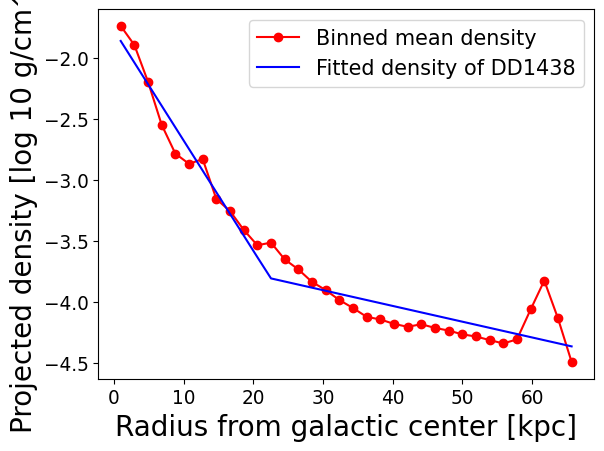

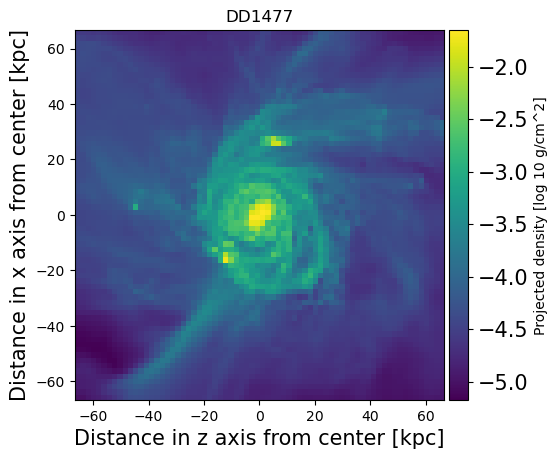

yt : [INFO     ] 2023-07-27 11:04:06,328 Parameters: current_time              = 402.31652781829
yt : [INFO     ] 2023-07-27 11:04:06,329 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:04:06,329 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:04:06,331 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:04:06,332 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:04:06,333 Parameters: current_redshift          = 0.50007848881181
yt : [INFO     ] 2023-07-27 11:04:06,333 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:04:06,334 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:04:06,334 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 11:04:06,335 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1478/DD1478
get_refine_box: using this location:       col1         col2    col3     col4     col5    col6     col7   col8
---------------- ------- -------- -------- ------- -------- -------- ----
0.50007848881181 0.49038 0.477011 0.505667 0.49238 0.479011 0.507667    9


Parsing Hierarchy : 100%|█████████████████| 5947/5947 [00:00<00:00, 6393.27it/s]
yt : [INFO     ] 2023-07-27 11:04:07,533 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:05:27,773 Projection completed
yt : [INFO     ] 2023-07-27 11:05:27,775 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


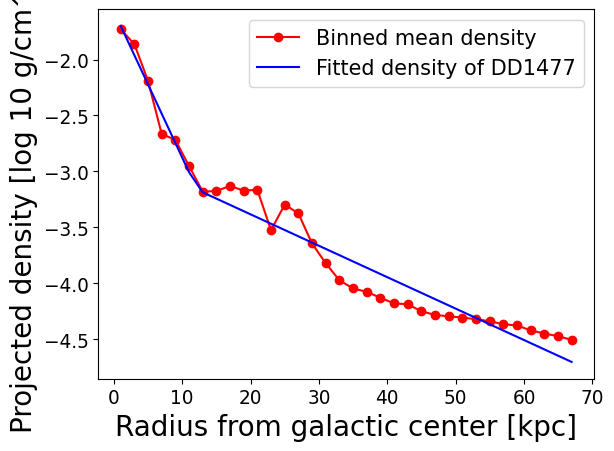

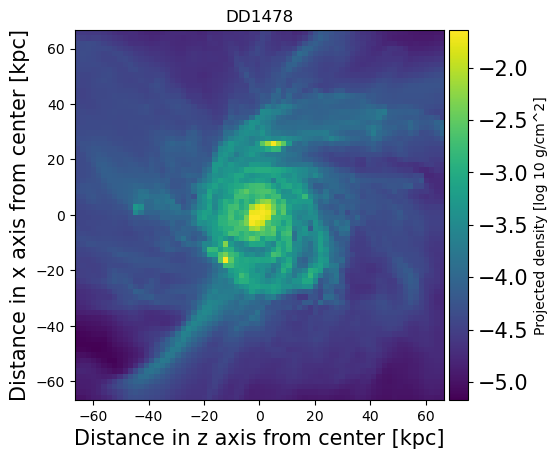

yt : [INFO     ] 2023-07-27 11:05:29,004 Parameters: current_time              = 402.56652517609
yt : [INFO     ] 2023-07-27 11:05:29,005 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:05:29,005 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:05:29,006 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:05:29,007 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:05:29,007 Parameters: current_redshift          = 0.49933608114367
yt : [INFO     ] 2023-07-27 11:05:29,008 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:05:29,009 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:05:29,009 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 11:05:29,010 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1479/DD1479
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.49933608114367 0.490378 0.477002 0.505671 0.492378 0.479002 0.507671    9


Parsing Hierarchy : 100%|█████████████████| 5985/5985 [00:00<00:00, 7015.62it/s]
yt : [INFO     ] 2023-07-27 11:05:30,159 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:06:47,306 Projection completed
yt : [INFO     ] 2023-07-27 11:06:47,308 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


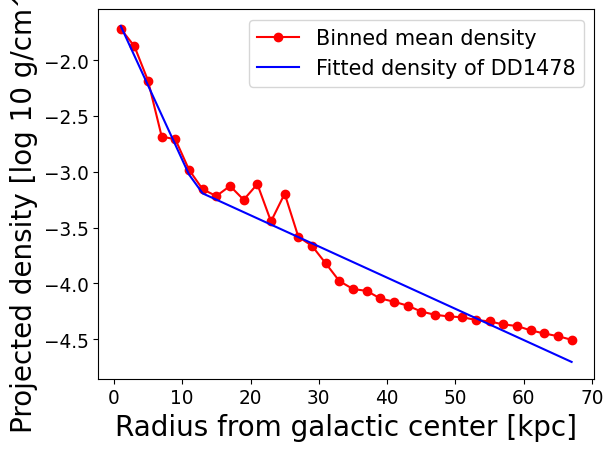

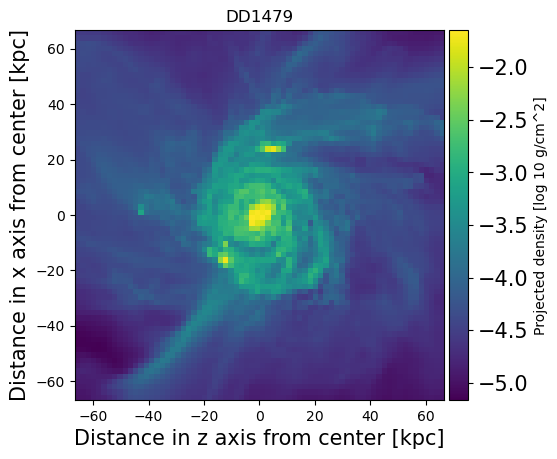

yt : [INFO     ] 2023-07-27 11:06:48,017 Parameters: current_time              = 417.31652781829
yt : [INFO     ] 2023-07-27 11:06:48,018 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:06:48,018 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:06:48,020 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:06:48,021 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:06:48,022 Parameters: current_redshift          = 0.45670560906839
yt : [INFO     ] 2023-07-27 11:06:48,022 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:06:48,023 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:06:48,024 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-27 11:06:48,025 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1538/DD1538
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.45670560906839 0.490252 0.476517 0.505875 0.492252 0.478517 0.507875    9


Parsing Hierarchy : 100%|█████████████████| 6119/6119 [00:00<00:00, 6722.45it/s]
yt : [INFO     ] 2023-07-27 11:06:49,204 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:08:08,676 Projection completed
yt : [INFO     ] 2023-07-27 11:08:08,678 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


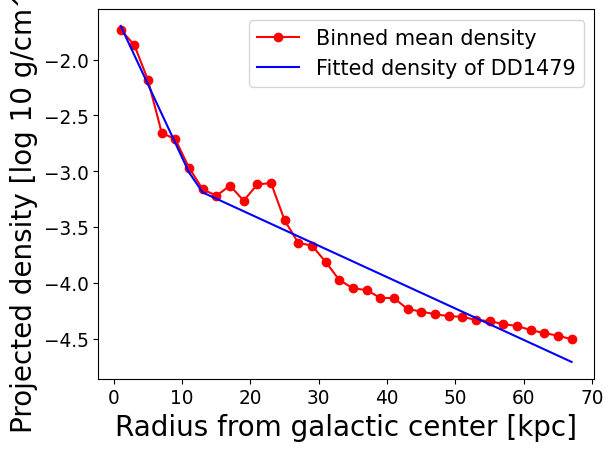

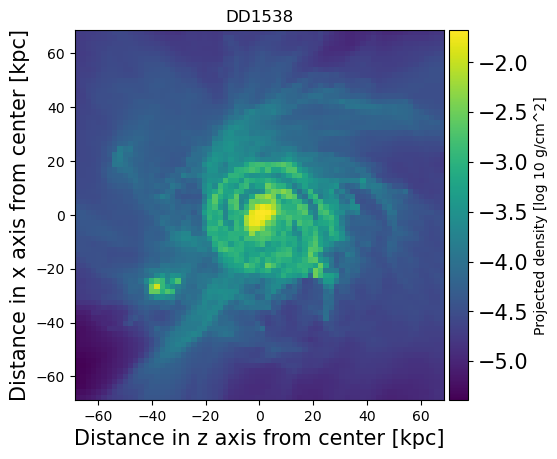

yt : [INFO     ] 2023-07-27 11:08:09,283 Parameters: current_time              = 442.31652781829
yt : [INFO     ] 2023-07-27 11:08:09,283 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:08:09,284 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:08:09,285 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:08:09,286 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:08:09,287 Parameters: current_redshift          = 0.3892837031507
yt : [INFO     ] 2023-07-27 11:08:09,288 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:08:09,288 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:08:09,289 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:08:09,289 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1638/DD1638
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.38929394169243 0.490071 0.475697 0.506226 0.492071 0.477697 0.508226    9


Parsing Hierarchy : 100%|█████████████████| 5613/5613 [00:00<00:00, 7139.35it/s]
yt : [INFO     ] 2023-07-27 11:08:10,315 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:09:23,159 Projection completed
yt : [INFO     ] 2023-07-27 11:09:23,162 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


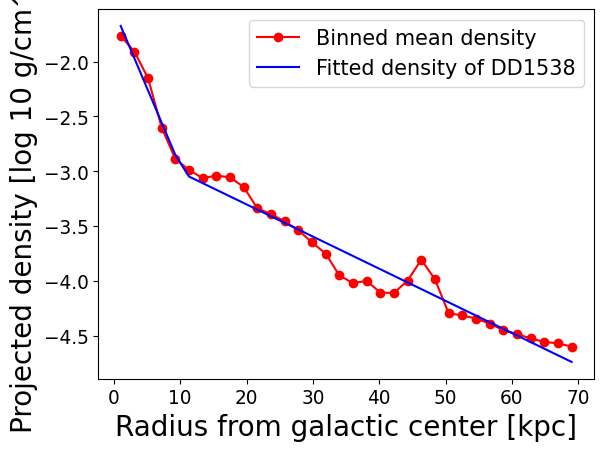

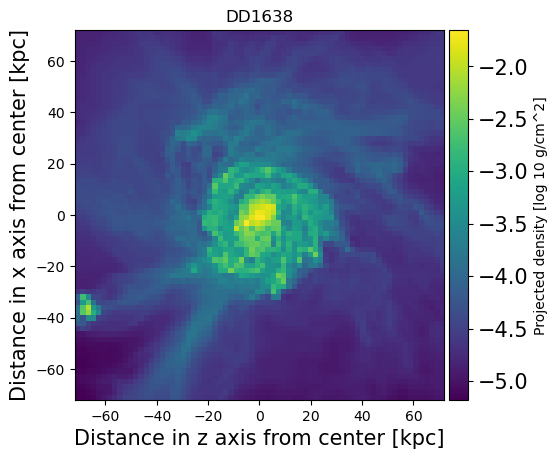

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1738/DD1738


yt : [INFO     ] 2023-07-27 11:09:23,873 Parameters: current_time              = 467.31652781829
yt : [INFO     ] 2023-07-27 11:09:23,874 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:09:23,875 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:09:23,876 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:09:23,877 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:09:23,877 Parameters: current_redshift          = 0.32721407621449
yt : [INFO     ] 2023-07-27 11:09:23,878 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:09:23,879 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:09:23,880 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:09:23,880 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.32722883488872 0.489878 0.474896 0.506564 0.491878 0.476896 0.508564    9


Parsing Hierarchy : 100%|█████████████████| 5309/5309 [00:00<00:00, 5378.43it/s]
yt : [INFO     ] 2023-07-27 11:09:25,101 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:10:32,934 Projection completed
yt : [INFO     ] 2023-07-27 11:10:32,936 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


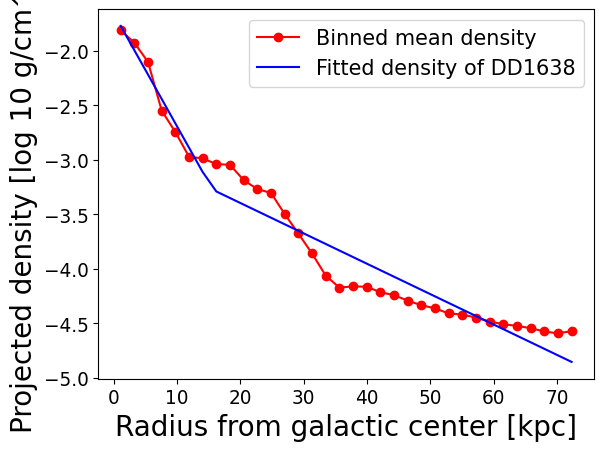

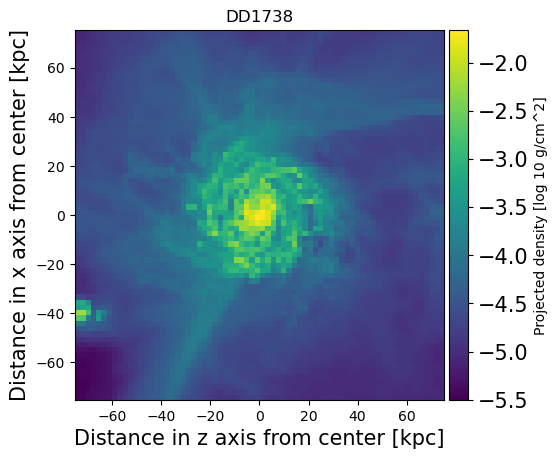

yt : [INFO     ] 2023-07-27 11:10:33,549 Parameters: current_time              = 492.31652781829
yt : [INFO     ] 2023-07-27 11:10:33,550 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:10:33,551 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:10:33,553 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:10:33,553 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:10:33,554 Parameters: current_redshift          = 0.26978215732692
yt : [INFO     ] 2023-07-27 11:10:33,555 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:10:33,555 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:10:33,556 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:10:33,557 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1838/DD1838
get_refine_box: using this location:       col1        col2     col3     col4     col5     col6     col7   col8
--------------- -------- -------- -------- -------- -------- -------- ----
0.2697939304999 0.489703 0.474121 0.506863 0.491703 0.476121 0.508863    9


Parsing Hierarchy : 100%|█████████████████| 5365/5365 [00:00<00:00, 5555.38it/s]
yt : [INFO     ] 2023-07-27 11:10:34,754 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:11:45,072 Projection completed
yt : [INFO     ] 2023-07-27 11:11:45,074 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


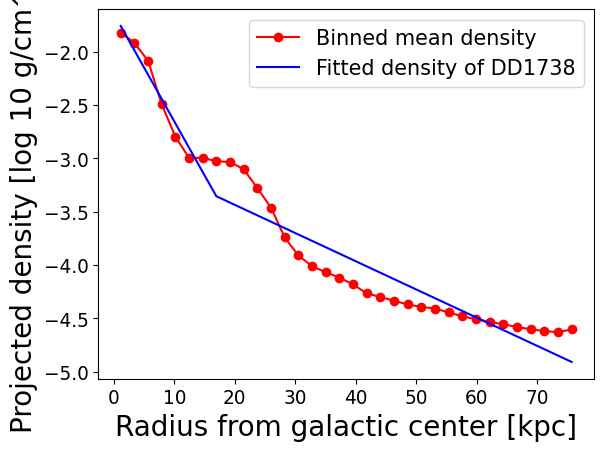

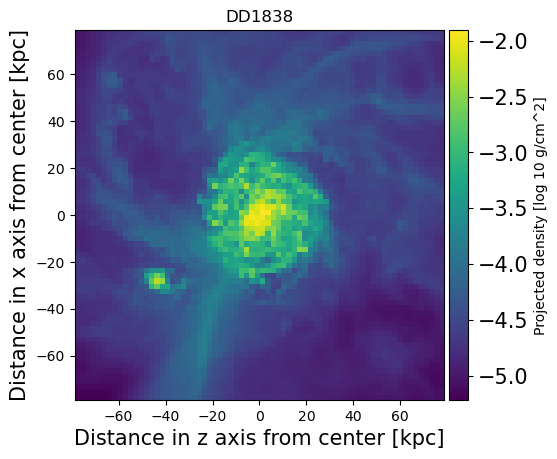

yt : [INFO     ] 2023-07-27 11:11:45,731 Parameters: current_time              = 517.31652781829
yt : [INFO     ] 2023-07-27 11:11:45,732 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:11:45,733 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:11:45,734 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:11:45,735 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:11:45,736 Parameters: current_redshift          = 0.21639444449422
yt : [INFO     ] 2023-07-27 11:11:45,737 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:11:45,737 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:11:45,738 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:11:45,739 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1938/DD1938
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.21640266677445 0.489548 0.473393 0.507161 0.491548 0.475393 0.509161    9


Parsing Hierarchy : 100%|█████████████████| 4944/4944 [00:00<00:00, 5537.45it/s]
yt : [INFO     ] 2023-07-27 11:11:47,226 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:12:51,337 Projection completed
yt : [INFO     ] 2023-07-27 11:12:51,339 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


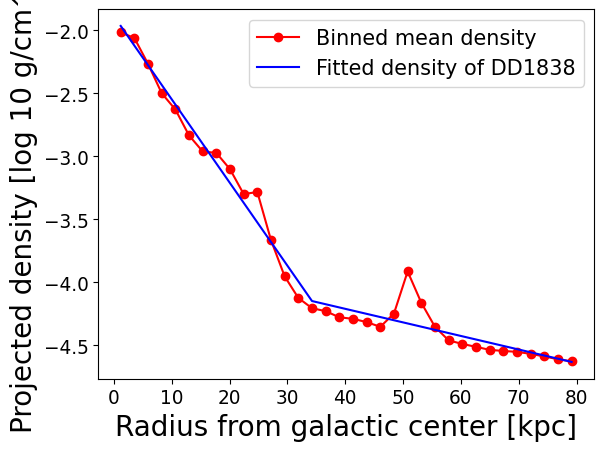

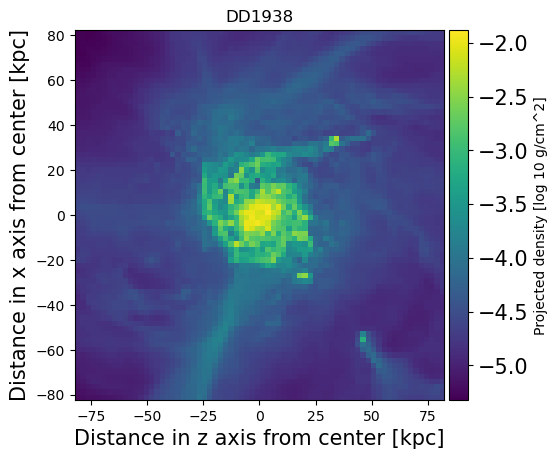

yt : [INFO     ] 2023-07-27 11:12:52,146 Parameters: current_time              = 542.31652781829
yt : [INFO     ] 2023-07-27 11:12:52,147 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:12:52,147 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:12:52,149 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:12:52,150 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:12:52,151 Parameters: current_redshift          = 0.1665627895111
yt : [INFO     ] 2023-07-27 11:12:52,151 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:12:52,152 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:12:52,153 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:12:52,153 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2038/DD2038
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.16656997024797 0.489403 0.472708 0.507468 0.491403 0.474708 0.509468    9


Parsing Hierarchy : 100%|█████████████████| 5224/5224 [00:00<00:00, 7257.95it/s]
yt : [INFO     ] 2023-07-27 11:12:53,111 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:13:59,906 Projection completed
yt : [INFO     ] 2023-07-27 11:13:59,908 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


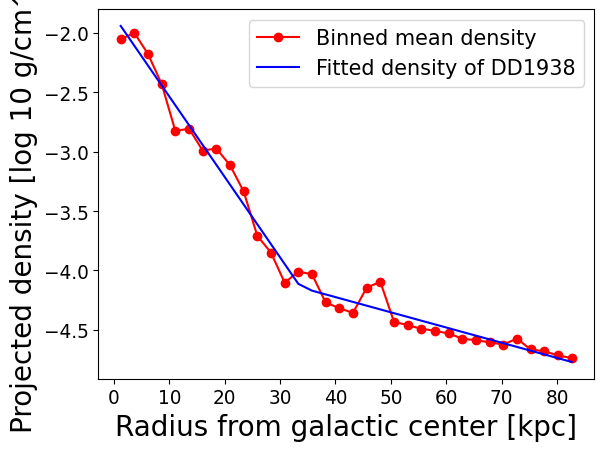

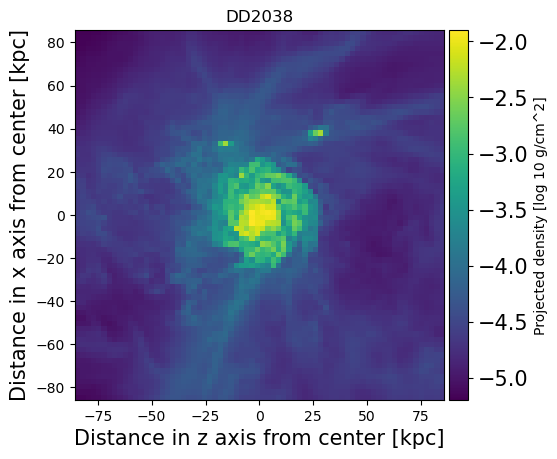

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2138/DD2138


yt : [INFO     ] 2023-07-27 11:14:00,815 Parameters: current_time              = 567.31652781829
yt : [INFO     ] 2023-07-27 11:14:00,816 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:14:00,819 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:14:00,821 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:14:00,822 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:14:00,822 Parameters: current_redshift          = 0.11988207020675
yt : [INFO     ] 2023-07-27 11:14:00,823 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:14:00,823 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:14:00,824 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:14:00,825 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.11989107535193 0.489254 0.472056 0.507771 0.491254 0.474056 0.509771    9


Parsing Hierarchy : 100%|█████████████████| 4682/4682 [00:00<00:00, 6401.58it/s]
yt : [INFO     ] 2023-07-27 11:14:01,761 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:15:02,740 Projection completed
yt : [INFO     ] 2023-07-27 11:15:02,741 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


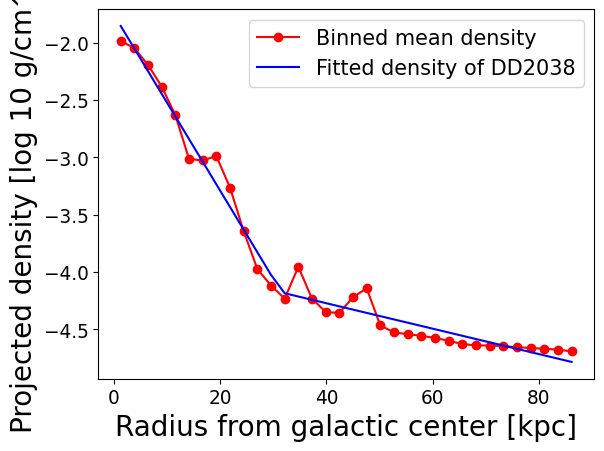

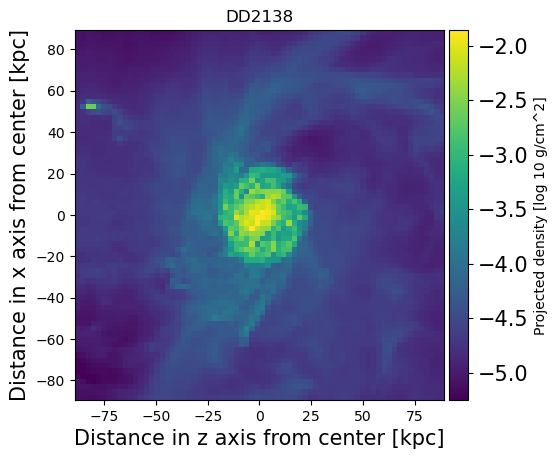

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2238/DD2238


yt : [INFO     ] 2023-07-27 11:15:03,491 Parameters: current_time              = 592.31652781829
yt : [INFO     ] 2023-07-27 11:15:03,492 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:15:03,493 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:15:03,494 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:15:03,496 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:15:03,497 Parameters: current_redshift          = 0.076013204837093
yt : [INFO     ] 2023-07-27 11:15:03,498 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:15:03,498 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:15:03,499 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:15:03,499 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.076025451160672 0.489123 0.471432 0.508053 0.491123 0.473432 0.510053    9


Parsing Hierarchy : 100%|█████████████████| 4688/4688 [00:00<00:00, 5533.57it/s]
yt : [INFO     ] 2023-07-27 11:15:04,575 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:16:05,964 Projection completed
yt : [INFO     ] 2023-07-27 11:16:05,966 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


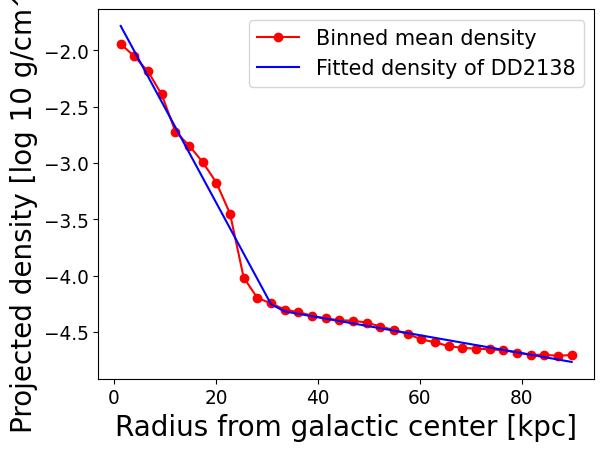

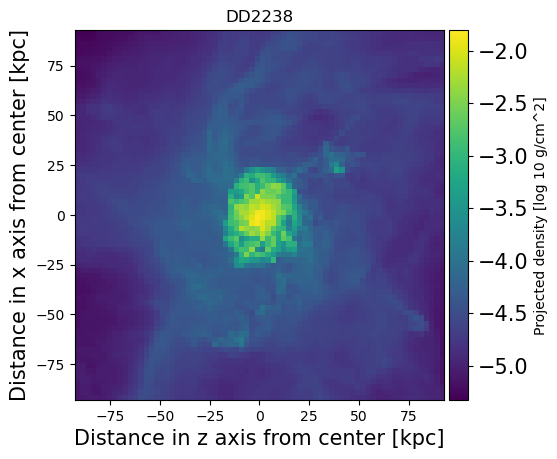

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2288/DD2288


yt : [INFO     ] 2023-07-27 11:16:06,868 Parameters: current_time              = 604.81652781829
yt : [INFO     ] 2023-07-27 11:16:06,868 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:16:06,869 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:16:06,870 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:16:06,871 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:16:06,871 Parameters: current_redshift          = 0.055049291735707
yt : [INFO     ] 2023-07-27 11:16:06,872 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:16:06,873 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:16:06,874 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:16:06,874 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.055055663741937 0.489056 0.471131 0.508189 0.491056 0.473131 0.510189    9


Parsing Hierarchy : 100%|█████████████████| 4745/4745 [00:01<00:00, 2818.05it/s]
yt : [INFO     ] 2023-07-27 11:16:08,957 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:17:14,865 Projection completed
yt : [INFO     ] 2023-07-27 11:17:14,867 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


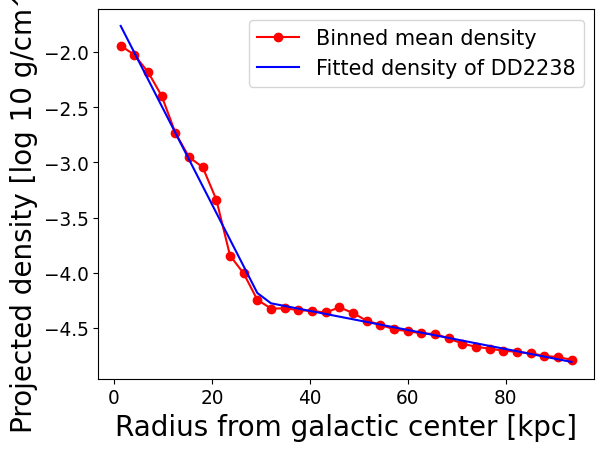

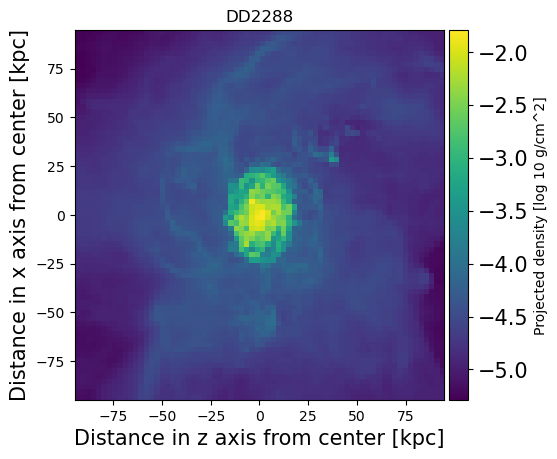

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2289/DD2289


yt : [INFO     ] 2023-07-27 11:17:15,615 Parameters: current_time              = 605.06652781829
yt : [INFO     ] 2023-07-27 11:17:15,616 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:17:15,618 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:17:15,618 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:17:15,619 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:17:15,620 Parameters: current_redshift          = 0.054634911934635
yt : [INFO     ] 2023-07-27 11:17:15,620 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:17:15,621 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:17:15,622 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:17:15,622 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.054642475638284 0.489054 0.471125 0.508191 0.491054 0.473125 0.510191    9


Parsing Hierarchy : 100%|█████████████████| 4798/4798 [00:00<00:00, 6689.53it/s]
yt : [INFO     ] 2023-07-27 11:17:16,578 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:18:22,807 Projection completed
yt : [INFO     ] 2023-07-27 11:18:22,808 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


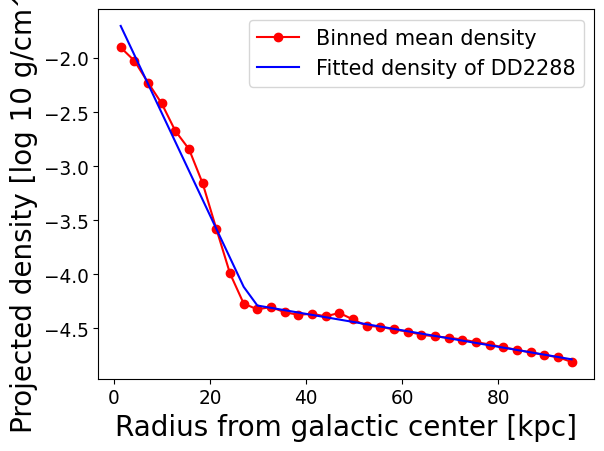

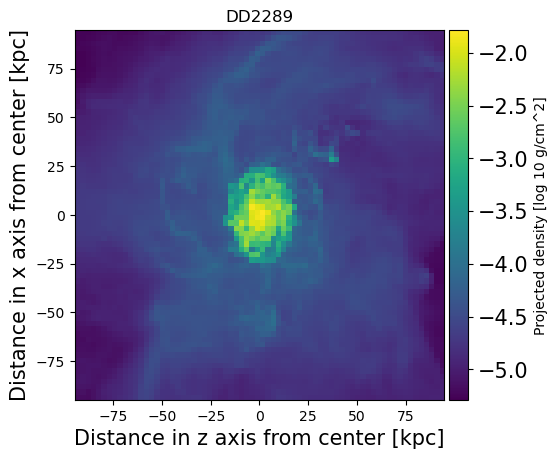

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2338/DD2338


yt : [INFO     ] 2023-07-27 11:18:23,772 Parameters: current_time              = 617.31652781829
yt : [INFO     ] 2023-07-27 11:18:23,773 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:18:23,774 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:18:23,775 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:18:23,776 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:18:23,776 Parameters: current_redshift          = 0.034670076640073
yt : [INFO     ] 2023-07-27 11:18:23,777 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:18:23,777 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:18:23,778 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:18:23,779 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4    col5     col6     col7  col8
----------------- -------- -------- ------- -------- -------- ------- ----
0.034684446722936 0.488987 0.470833 0.50832 0.490987 0.472833 0.51032    9


Parsing Hierarchy : 100%|█████████████████| 4505/4505 [00:00<00:00, 5237.99it/s]
yt : [INFO     ] 2023-07-27 11:18:24,868 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:19:25,426 Projection completed
yt : [INFO     ] 2023-07-27 11:19:25,428 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


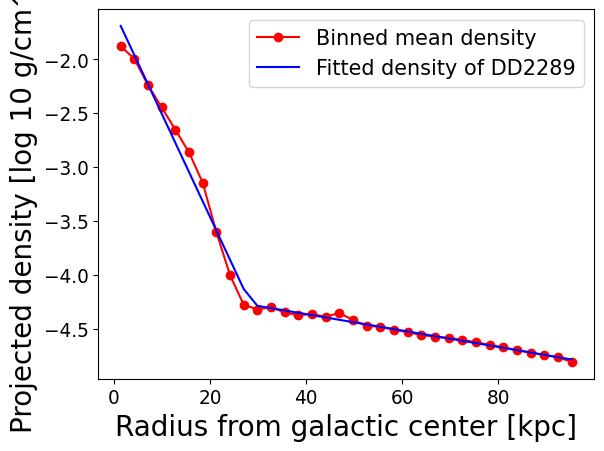

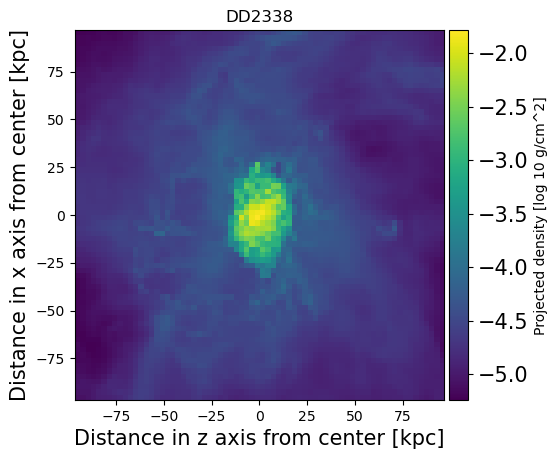

yt : [INFO     ] 2023-07-27 11:19:26,057 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2023-07-27 11:19:26,058 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-27 11:19:26,060 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-27 11:19:26,060 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-27 11:19:26,061 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-27 11:19:26,062 Parameters: current_redshift          = 0
yt : [INFO     ] 2023-07-27 11:19:26,063 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-27 11:19:26,063 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-27 11:19:26,064 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-27 11:19:26,065 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2427/DD2427
get_refine_box: using this location:         col1          col2     col3     col4    col5     col6     col7  col8
------------------- -------- -------- ------- -------- -------- ------- ----
4.4408920985006e-16 0.488865 0.470316 0.50854 0.490865 0.472316 0.51054    9


Parsing Hierarchy : 100%|█████████████████| 4262/4262 [00:00<00:00, 4588.75it/s]
yt : [INFO     ] 2023-07-27 11:19:27,219 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-27 11:20:25,474 Projection completed
yt : [INFO     ] 2023-07-27 11:20:25,476 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


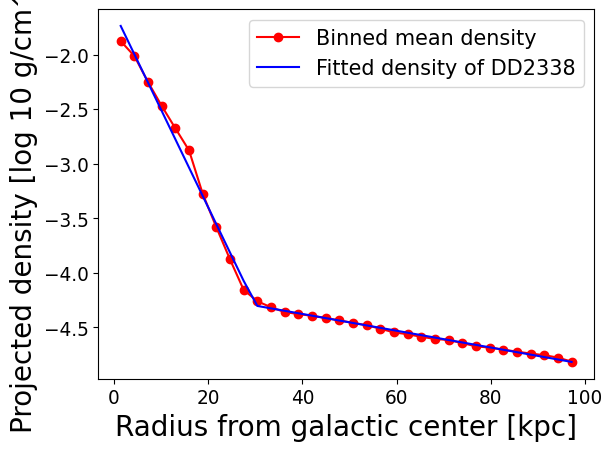

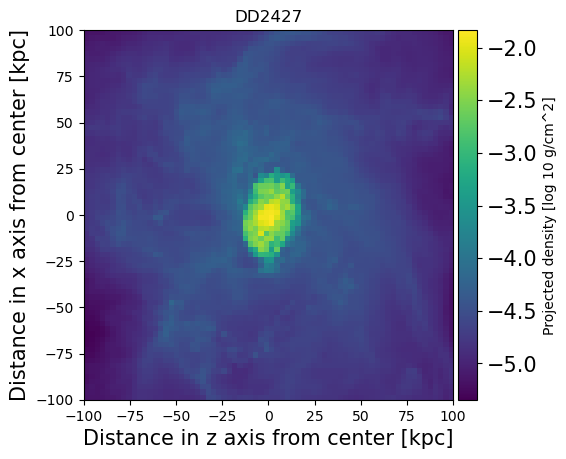

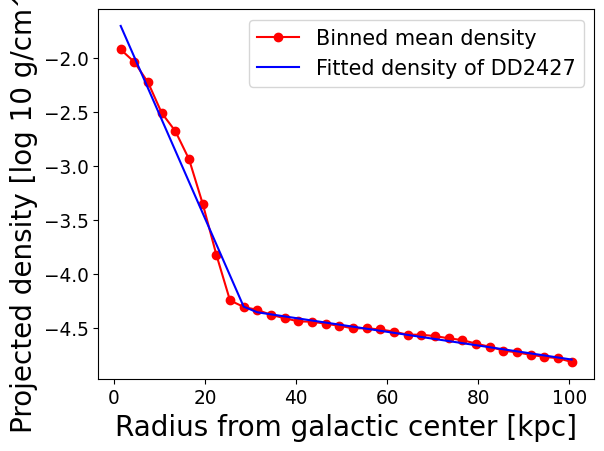

In [8]:
redshiftlist = [] #This part will be replaced with pandas later. 
cutofflist = [] #same 
timelist = [] #same 

for DD in sorted_dd_list:
    try:  
        snap = DD  # name of the snapshot output 
        plotlabel_segment = 'Fitted density of' + " " + snap
        snap_fullpath = simulation_dir + snap + '/' + snap # full path of where the snapshot output lives

        ds, refine_box = foggie_load(snap_fullpath, track_name, halo_c_v_name=track_dir + 'halo_c_v',
                                  disk_relative=False, do_filter_particles=False, masses_dir=track_dir)
        
        z = ds.get_parameter("CosmologyCurrentRedshift")
        current_time = ds.current_time.in_units('Gyr').value
        width = 200/(1+z) #[kpc]
        max_radius = width/2 #[kpc]
        binsize = 3/(z+1) #[kpc]
        
        #Density cutoff part should be here. 
    
        frb = frb_projection(ds, field, axis, refine_box, width, resolution, weight_field = None)

        OD_Rad, OD_Qua = radius_func(np.array(frb["gas",field]), width, resolution)

        radiuslist, quantitylist =  binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize)
        
        radiuslist = np.ma.compressed(np.ma.masked_where(np.isnan(quantitylist), radiuslist))

        quantitylist  = np.ma.compressed(np.ma.masked_where(np.isnan(quantitylist), quantitylist))
     
        p , e = optimize.curve_fit(piecewise_linear, radiuslist, np.log10(quantitylist), 
                                   p0 = [7.5, -3.91229778e+00, -1.21229325e-01, -6.12439042e-03])
        #[22.5,-4,-0.1,-0.01]
        #p : popt(optimization parameter) / e : pcov(covariance of popt)

        projection_plot = projection(frb, field, width, colorlabel, axis, snap, fontsize = 15)
        segment_plot = plotting(radiuslist, np.log10(quantitylist), piecewise_linear(radiuslist, *p),
                        'ro-','b-', plotlabel_linedot, plotlabel_segment)
 
        segment_plot.savefig(output_dir + snap + "_Density_Profile.jpg", bbox_inches = 'tight')
        projection_plot.savefig(output_dir + snap + "_Density_Projection_Plot.jpg")
    
        timepara = ds.current_time.in_units('Gyr').value + 0
        redshiftlist.append(z) #[z]
        cutofflist.append(p[0]) #[kpc]
        timelist.append(timepara) #[Gyr]
        
    except:
        print("Error with" +" "+ snap)
        pass 

In [9]:
#pandadata = {'Rdshift' : redshiftlist, 'Current time' : timelist, 'Cut-off radius' : cutofflist}
#Pd_dataframe = pd.DataFrame(data=d)
#Pd_dataframe4

In [10]:
cutofflist_y = cutofflist

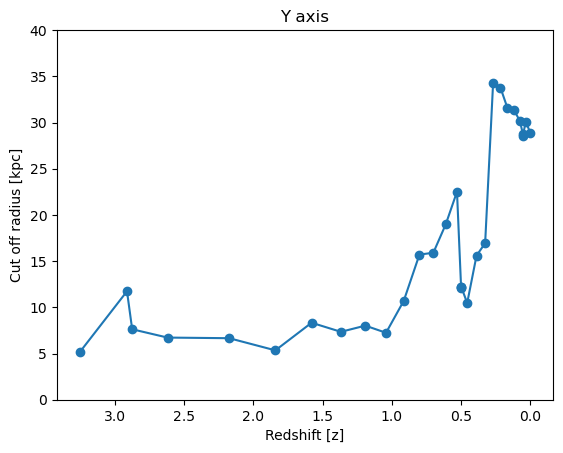

In [11]:
plt.plot(redshiftlist, cutofflist,'-o')
plt.ylabel("Cut off radius [kpc]") #actually in kpc 
plt.ylim([0,40])
plt.xlabel("Redshift [z]")
plt.title("Y axis")
plt.gca().invert_xaxis()

In [12]:
cutofflist
#1st, density cut off too aggressive and 2nd, bounds for optimization. no negatifel. 

[5.12205809118759,
 11.739109959543818,
 7.625583045629417,
 6.725967841957136,
 6.6575369329846525,
 5.342056922365368,
 8.331416843638445,
 7.3481233776540735,
 8.018789814648722,
 7.244725048000589,
 10.700742210167576,
 15.705497257873507,
 15.905864848042869,
 18.984980507311736,
 22.512280225236893,
 12.200794777373469,
 12.078149315570055,
 12.200687097910185,
 10.467213260932198,
 15.596848716245113,
 16.94089967924108,
 34.25784426539893,
 33.76209539286167,
 31.58473875495007,
 31.370909997526542,
 30.157882295876025,
 28.759371876485844,
 28.559274916615458,
 30.07699867651771,
 28.86722883564776]

In [13]:
timelist_y = timelist

In [15]:
redshiftlist_y = redshiftlist

In [18]:
np.save('y_axis_redshift', redshiftlist_y)

In [19]:
np.save('y_axis_timelist', timelist_y)

In [20]:
np.save('y_axis_cutofflist', cutofflist)